#imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
from functools import partial
import json
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance


from geopy.distance import geodesic
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from scipy import stats
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
rmse = partial(mean_squared_error, squared=False)
rmsle = partial(mean_squared_log_error, squared=False)

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
!pip install -q category_encoders
from category_encoders import TargetEncoder, LeaveOneOutEncoder, WOEEncoder
!pip install -q catboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
from catboost import CatBoostRegressor

import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
DEVICE_XGB = 'gpu_hist' if torch.cuda.is_available() else 'auto'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)

!pip install -q optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [3]:
from tabulate import tabulate

def display_column_info(data):
    column_info = []
    for column in data.columns:
        unique_values = data[column].nunique()
        data_type = data[column].dtype
        missing_values = data[column].isnull().sum()
        missing_percentage = (missing_values / len(data)) * 100
        column_info.append([
            column,
            unique_values,
            data_type,
            missing_values,
            f"{missing_percentage:.2f}%"
        ])

    headers = ['Column', 'Unique Values', 'Data Type', 'Missing Values', 'Missing Value %']
    return tabulate(column_info, headers=headers, tablefmt="grid")

In [4]:
def plot_numeric_columns(data, timestamp_column, device_column, null_marker='x', null_color='red'):
    numeric_columns = data.select_dtypes(include=['int', 'float']).columns
    devices = data[device_column].unique()

    for column in numeric_columns:
        if column != timestamp_column:
            plt.figure(figsize=(12, 6))
            for device in devices:
                device_data = data[data[device_column] == device]

                # Get the indices of null values
                null_indices = np.isnan(device_data[column])

                # Plot non-null values
                plt.scatter(device_data[timestamp_column][~null_indices], device_data[column][~null_indices], label=device)

                # Plot null values
                plt.scatter(device_data[timestamp_column][null_indices], device_data[column][null_indices], marker=null_marker, color=null_color)

            plt.xlabel(timestamp_column)
            plt.ylabel(column)
            plt.title(f"{column} over {timestamp_column}")
            plt.legend()
            plt.show()

In [5]:
def analyze_missing_data(data):
    # Calculate the total missing values in each column
    missing_values = data.isnull().sum()

    # Calculate the percentage of missing values in each column
    missing_percentages = (missing_values / len(data)) * 100

    # Create a dataframe to store the missing data statistics
    missing_data = pd.DataFrame({'Column': data.columns, 'Missing Values': missing_values, 'Missing Percentage': missing_percentages})

    # Filter columns with missing values
    missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Percentage', ascending=False)

    # Plot the missing data statistics
    plt.figure(figsize=(12, 6))
    sns.barplot(data=missing_data, x='Column', y='Missing Percentage', palette='viridis')
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage')
    plt.title('Missing Data Analysis')
    plt.show()

    # Display the missing data statistics table
    print(missing_data)

In [6]:
def map_columns_with_target(data, columns, target):
    correlations = {}

    for column in columns:
        correlation = np.corrcoef(data[column], data[target])[0, 1]
        correlations[column] = correlation

    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    for column, correlation in sorted_correlations:
        print(f"Column: {column}\t\tCorrelation: {correlation:.4f}")

    # Plotting correlation heatmap
    corr_matrix = data[columns + [target]].corr()
    plt.figure(figsize=(20, 16))
    plt.title('Correlation Heatmap')
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.xticks(np.arange(len(columns) + 1), columns + [target], rotation=45)
    plt.yticks(np.arange(len(columns)), columns)
    plt.colorbar()
    plt.show()

*italicized text*
# Data loading

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/QoS Prediction Challenge/Train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/QoS Prediction Challenge/Test.csv")
train_df["data_type"] = 0
test_df["data_type"] = 1
df_all =  pd.concat([train_df.drop('id',axis=1), test_df.drop('id',axis=1)], ignore_index=True)
sample_submission = pd.read_csv('/content/drive/MyDrive/QoS Prediction Challenge/SampleSubmission.csv')
trinfo = display_column_info(train_df)
teinfo = display_column_info(test_df)
allinfo = display_column_info(df_all)

In [8]:
df_all

,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,SCell_RSRP_max,SCell_RSRQ_max,SCell_RSSI_max,SCell_SNR_max,SCell_Downlink_Num_RBs,SCell_Downlink_Average_MCS,SCell_Downlink_bandwidth_MHz,SCell_Cell_Identity,SCell_freq_MHz,operator,Latitude,Longitude,Altitude,speed_kmh,COG,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target,data_type
0,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,26368258.0,1800.0,-87.075625,-10.159375,-56.209375,17.690,36756.0,19.0,NaN,NaN,2600.0,1,52.499828,13.313497,42.1,0.0000,295.6,0.0000,0.00,21.56,21.56,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0,0
1,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,2568970.0,1800.0,-93.598750,-12.158750,-62.156875,14.863,48372.0,14.0,20.0,2568967.0,2600.0,2,52.491645,13.304608,42.4,0.0000,159.0,0.0132,0.01,22.98,22.98,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0,0
2,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,2824458.0,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,52.499087,13.308002,46.1,0.0000,271.2,0.0081,0.01,22.57,22.57,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0,0
3,1624542066,pc1,-95.598750,-14.696250,-61.660000,10.726,95955.0,17.0,20.0,26367489.0,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.513472,13.330120,40.3,14.6308,169.0,0.1075,0.23,18.77,18.77,13.43,0.71,1017.9,1.97,0.99,3.0,16.093,8.80702,Avenue,46400000.0,0
4,1624542798,pc1,-97.735000,-14.867500,-63.170625,10.889,83062.0,19.0,20.0,26369024.0,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.509828,13.355828,27.6,13.7048,262.4,0.0998,0.22,18.79,18.79,13.46,0.71,1017.9,1.97,0.99,3.0,16.093,2.21843,Park,50200000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52512,1624370207,pc2,-81.506250,-9.556875,-78.813125,24.005,49881.0,28.0,20.0,4000013.0,2600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,52.514962,13.357693,30.9,0.0000,86.4,0.0083,0.01,22.38,22.38,14.77,0.62,1013.8,2.12,0.84,3.0,16.093,1.82751,Park,NaN,1
52513,1624371137,pc2,-84.858750,-12.547500,-83.305000,11.985,29323.0,22.0,20.0,2940680.0,1800.0,-84.578750,-12.898125,-75.461250,5.725,37665.0,13.0,20.0,30829312.0,2600.0,2,52.504108,13.337022,46.7,35.7436,303.4,0.0075,0.01,22.42,22.42,14.69,0.62,1013.9,2.12,0.83,3.0,16.093,3.14159,Park,NaN,1
52514,1624376766,pc2,-82.406875,-12.343125,-79.631875,12.719,37837.0,21.0,20.0,2824458.0,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,52.499542,13.312725,44.0,0.0000,197.5,0.0241,0.01,23.87,23.87,14.78,0.57,1013.7,2.19,0.76,2.0,16.093,1.57307,Residential,NaN,1
52515,1624353986,pc4,-95.212500,-10.181875,-65.595625,11.800,47277.0,15.0,20.0,34006528.0,1800.0,-116.790000,-24.005000,-73.602500,-13.036,NaN,NaN,NaN,NaN,2600.0,1,52.515622,13.368560,28.6,38.7068,83.8,0.0238,0.02,18.80,18.80,13.92,0.73,1012.2,4.23,0.97,4.0,16.093,0.51020,Park,NaN,1


#EDA

In [9]:
print(allinfo)

+------------------------------+-----------------+-------------+------------------+-------------------+
| Column                       |   Unique Values | Data Type   |   Missing Values | Missing Value %   |
+==============================+=================+=============+==================+===================+
| timestamp                    |           27529 | int64       |                0 | 0.00%             |
+------------------------------+-----------------+-------------+------------------+-------------------+
| device                       |               4 | object      |                0 | 0.00%             |
+------------------------------+-----------------+-------------+------------------+-------------------+
| PCell_RSRP_max               |           38043 | float64     |                0 | 0.00%             |
+------------------------------+-----------------+-------------+------------------+-------------------+
| PCell_RSRQ_max               |           17640 | float64     |

Column: SCell_Downlink_Num_RBs		Correlation: nan
Column: SCell_Downlink_Average_MCS		Correlation: nan
Column: SCell_Downlink_bandwidth_MHz		Correlation: nan
Column: SCell_Cell_Identity		Correlation: nan
Column: SCell_freq_MHz		Correlation: nan
Column: operator		Correlation: nan
Column: Latitude		Correlation: nan
Column: Longitude		Correlation: nan
Column: Altitude		Correlation: nan
Column: speed_kmh		Correlation: nan
Column: COG		Correlation: nan
Column: precipIntensity		Correlation: nan
Column: precipProbability		Correlation: nan
Column: temperature		Correlation: nan
Column: apparentTemperature		Correlation: nan
Column: dewPoint		Correlation: nan
Column: humidity		Correlation: nan
Column: pressure		Correlation: nan
Column: windSpeed		Correlation: nan
Column: cloudCover		Correlation: nan
Column: uvIndex		Correlation: nan
Column: visibility		Correlation: nan
Column: Traffic Jam Factor		Correlation: nan


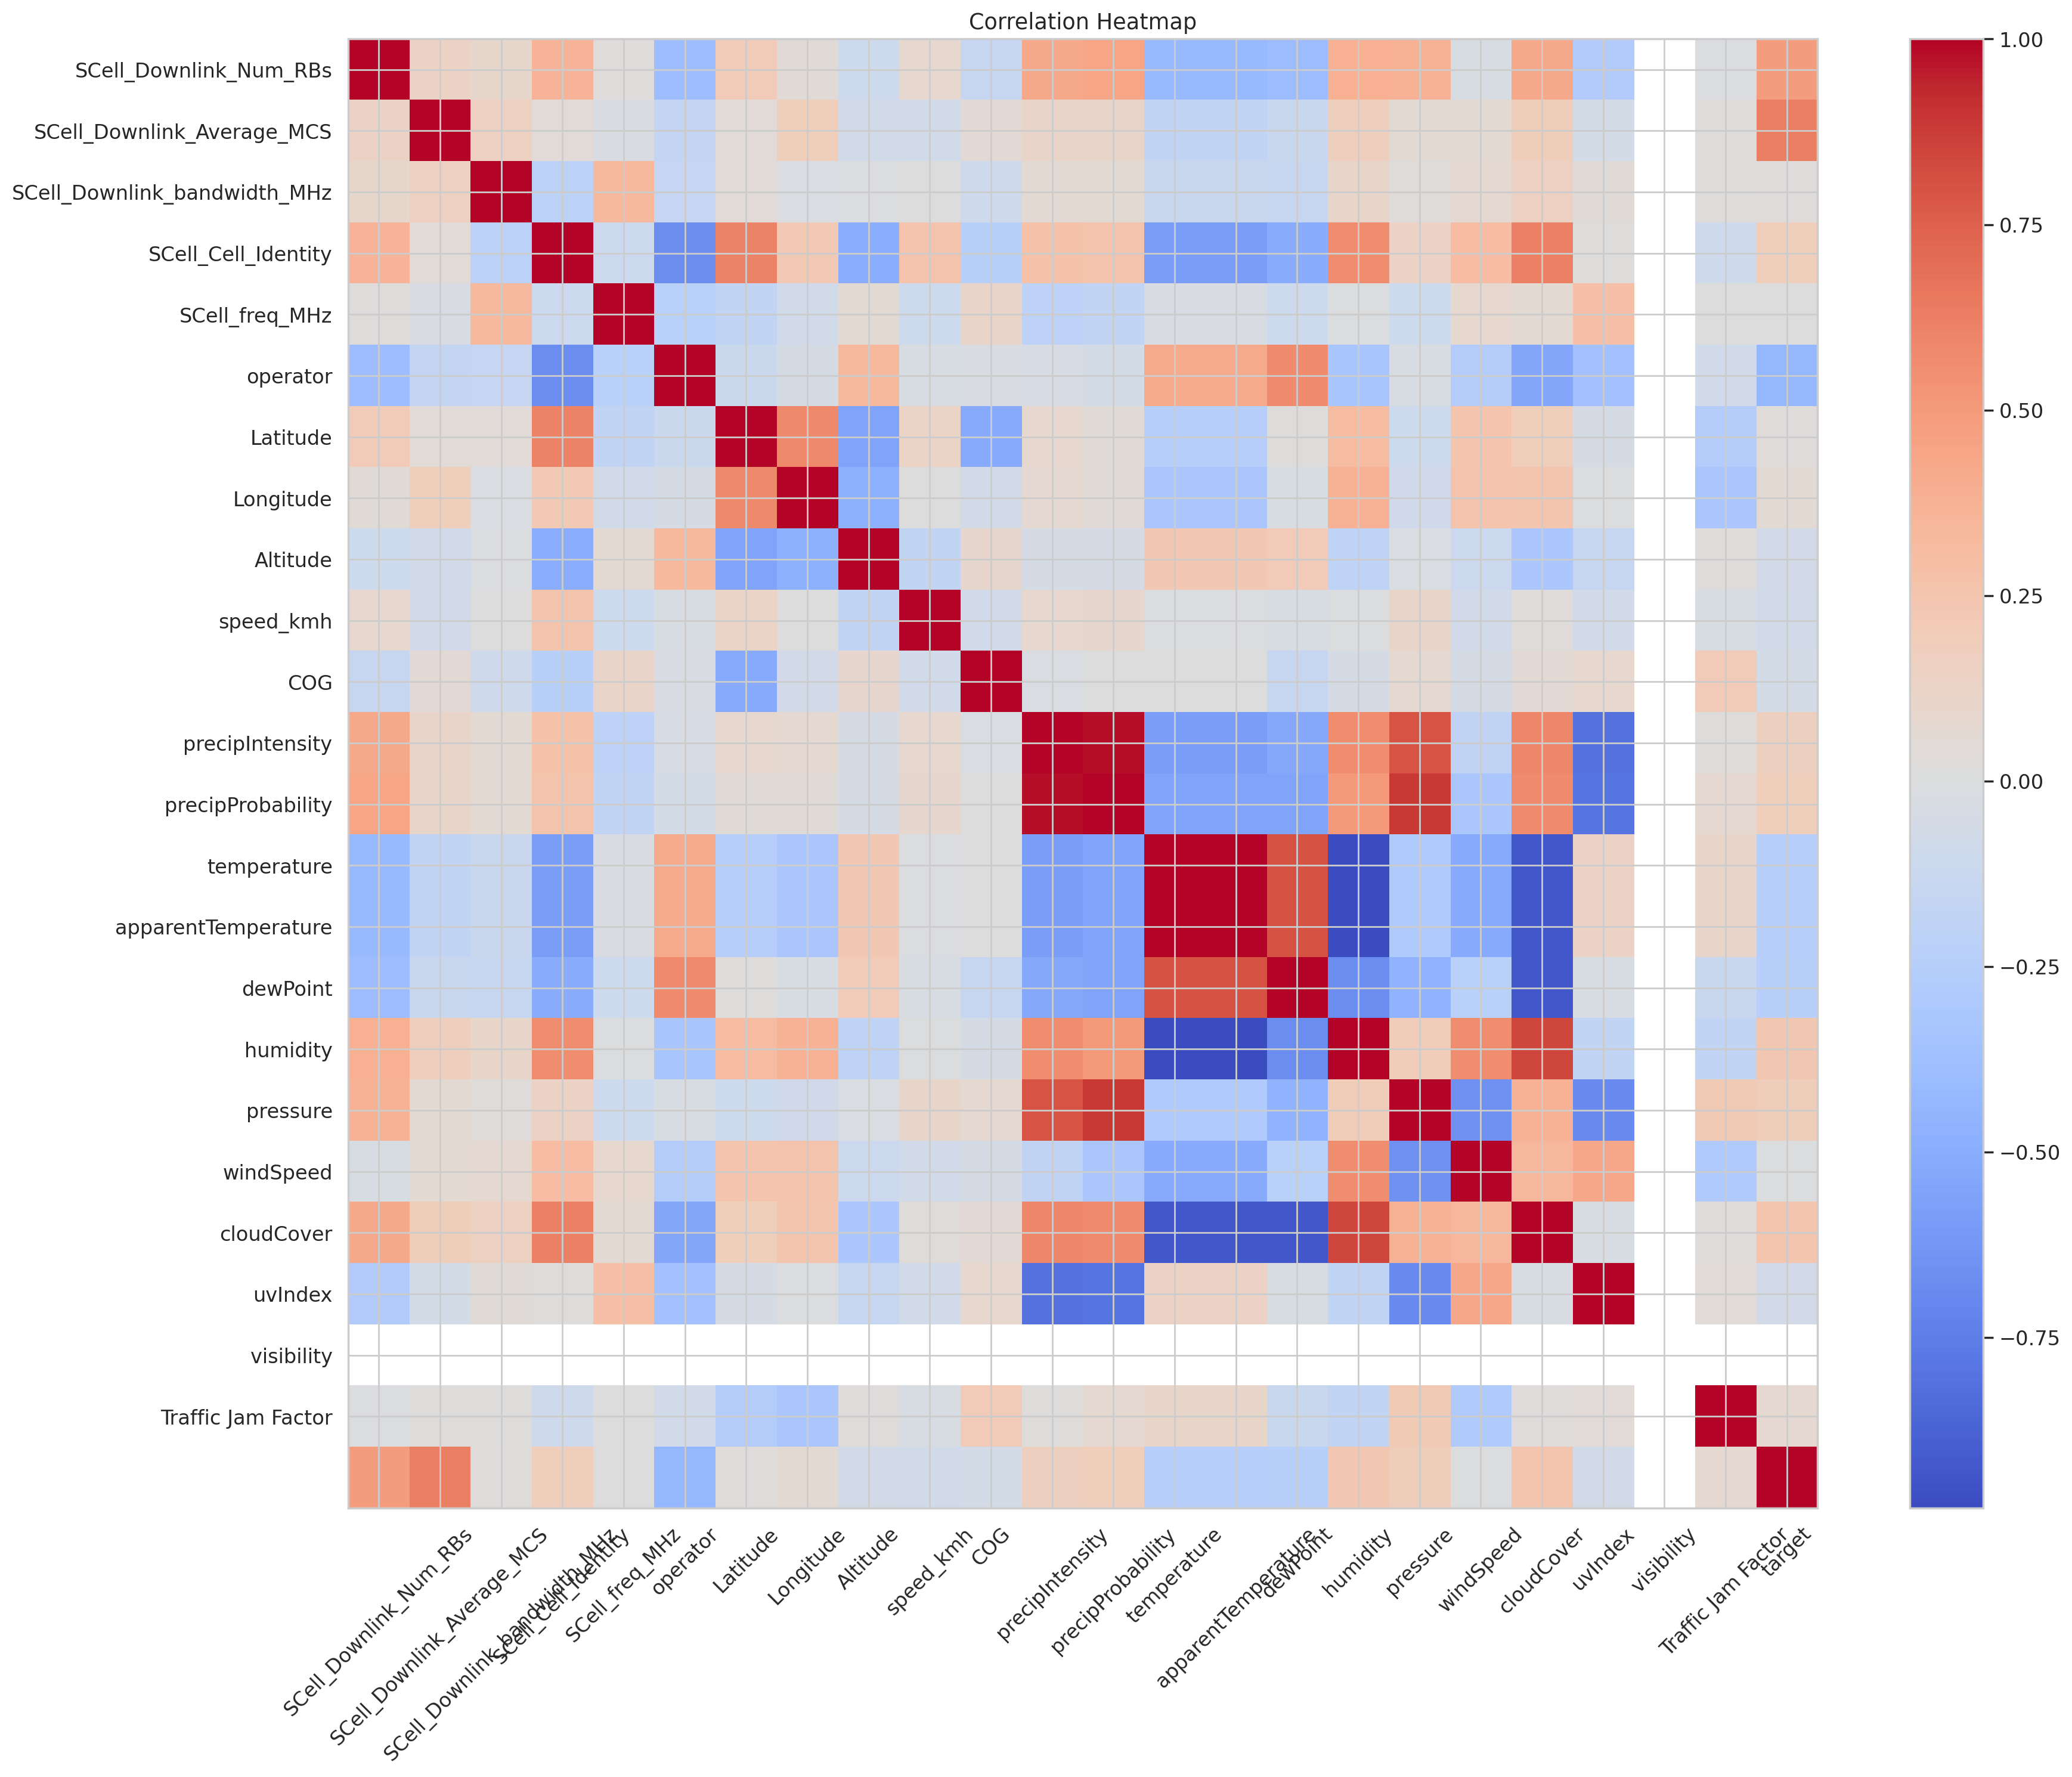

In [10]:
columns = ['SCell_Downlink_Num_RBs', 'SCell_Downlink_Average_MCS', 'SCell_Downlink_bandwidth_MHz', 'SCell_Cell_Identity',
           'SCell_freq_MHz', 'operator', 'Latitude', 'Longitude', 'Altitude',
           'speed_kmh', 'COG', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure',
           'windSpeed', 'cloudCover', 'uvIndex','visibility','Traffic Jam Factor']
map_columns_with_target(df_all, columns, 'target')

# Data preparation

In [12]:
from sklearn.impute import KNNImputer
features = ['PCell_Downlink_bandwidth_MHz', 'PCell_Cell_Identity', 'Traffic Jam Factor', 'Altitude']
#KNN imputation
imputer = KNNImputer(n_neighbors=10)  # Use appropriate imputation technique
df_all[features] = imputer.fit_transform(df_all[features])

In [13]:
# Create new features based on existing ones
#df_all['RSRP_diff'] = df_all['PCell_RSRP_max'].sub(df_all['SCell_RSRP_max'])
#df_all['RSRQ_diff'] = df_all['PCell_RSRQ_max'].sub(df_all['SCell_RSRQ_max'])
#df_all['RSSI_diff'] = df_all['PCell_RSSI_max'].sub(df_all['SCell_RSSI_max'])
#df_all['SNR_diff'] = df_all['PCell_SNR_max'].sub(df_all['SCell_SNR_max'])

# Handle null values
#df_all['RSRP_diff'].fillna(0, inplace=True)
#df_all['RSRQ_diff'].fillna(0, inplace=True)
#df_all['RSSI_diff'].fillna(0, inplace=True)
#df_all['SNR_diff'].fillna(0, inplace=True)

# Create ratio features and handle null values
#df_all['RSRP_ratio'] = df_all['PCell_RSRP_max'].div(df_all['SCell_RSRP_max'])
#df_all['RSRP_ratio'].fillna(1, inplace=True)
#df_all['RSRQ_ratio'] = df_all['PCell_RSRQ_max'].div(df_all['SCell_RSRQ_max'])
#df_all['RSRQ_ratio'].fillna(1, inplace=True)
#df_all['RSSI_ratio'] = df_all['PCell_RSSI_max'].div(df_all['SCell_RSSI_max'])
#df_all['RSSI_ratio'].fillna(1, inplace=True)
#df_all['SNR_ratio'] = df_all['PCell_SNR_max'].div(df_all['SCell_SNR_max'])
#df_all['SNR_ratio'].fillna(1, inplace=True)

# Create aggregated features and handle null values
df_all['Downlink_Avg_MCS_per_RBs'] = df_all['PCell_Downlink_Average_MCS'].div(df_all['PCell_Downlink_Num_RBs'])
df_all['Downlink_Avg_MCS_per_RBs'].fillna(0, inplace=True)

# Compute statistical features and handle null values
df_all['PCell_RSRP_max_mean'] = df_all['PCell_RSRP_max'].mean()
df_all['PCell_RSRP_max_mean'].fillna(0, inplace=True)

df_all['PCell_RSRP_max_std'] = df_all['PCell_RSRP_max'].std()
df_all['PCell_RSRP_max_std'].fillna(0, inplace=True)

#df_all['PCell_RSRP_max_min'] = df_all['PCell_RSRP_max'].min()
#df_all['PCell_RSRP_max_min'].fillna(0, inplace=True)

#df_all['PCell_RSRP_max_max'] = df_all['PCell_RSRP_max'].max()
#df_all['PCell_RSRP_max_max'].fillna(0, inplace=True)

# Binning or discretization example
bins = [-float('inf'), -90, -80, -70, float('inf')]
labels = ['Poor', 'Moderate', 'Good', 'Excellent']
df_all['RSRP_category'] = pd.cut(df_all['PCell_RSRP_max'], bins=bins, labels=labels)
df_all['RSRP_category'].fillna('Unknown', inplace=True)
# Define the binning thresholds
bins = [-np.inf, 0, 1000, 2000, np.inf]
labels = ['Sea Level', 'Low', 'Medium', 'High']

# Create the altitude category feature
df_all['Altitude_Category'] = pd.cut(df_all['Altitude'], bins=bins, labels=labels)

# Initialize the scaler
scaler = MinMaxScaler()
# Scale the altitude values
df_all['Altitude_Scaled'] = scaler.fit_transform(df_all['Altitude'].values.reshape(-1, 1))
# Create a feature indicating if the altitude is above a certain threshold
threshold = 1000
df_all['Above_Threshold'] = (df_all['Altitude'] > threshold).astype(int)

# Create a feature representing the squared altitude
df_all['Altitude_Squared'] = df_all['Altitude'] ** 2
# Create an interaction feature between altitude and temperature
df_all['Altitude_Temperature_Interaction'] = df_all['Altitude'] * df_all['temperature']

In [14]:
# Create a copy of the original dataset
df_processed = df_all.copy()

# Convert timestamp to datetime
df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'], unit='s')

# Extract periodic features
df_processed['hour'] = df_processed['timestamp'].dt.hour
df_processed['minute'] = df_processed['timestamp'].dt.minute
df_processed['day_of_week'] = df_processed['timestamp'].dt.dayofweek

# Perform target encoding for the 'area' feature
#area_target_mean = df_processed.groupby('area')['target'].mean()
#df_processed['area_target_mean'] = df_processed['area'].map(area_target_mean)

# Perform clustering on latitude and longitude
coordinates = df_processed[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=0)
df_processed['location_cluster'] = kmeans.fit_predict(coordinates)

cluster_size = df_processed['location_cluster'].value_counts()
df_processed['Cluster_Size'] = df_processed['location_cluster'].map(cluster_size)
cluster_means = df_processed.groupby('location_cluster')['temperature'].mean()
df_processed['Cluster_Temperature_Mean'] = df_processed['location_cluster'].map(cluster_means)
cluster_centers = kmeans.cluster_centers_
distances = []
for i in range(len(df_processed)):
    point = df_processed[['Latitude', 'Longitude']].iloc[i]
    cluster_label = df_processed['location_cluster'].iloc[i]
    centroid = cluster_centers[cluster_label]
    distances.append(distance.euclidean(point, centroid))

df_processed['Cluster_Centroid_Distance'] = distances
cluster_distances = pairwise_distances(cluster_centers)
df_processed['Cluster_Proximity'] = df_processed['location_cluster'].map(lambda x: cluster_distances[x].mean())

# Create count-based features
count_features = ['precipIntensity', 'Traffic Jam Factor']
for feature in count_features:
    window = '25min'
    window_size = int(timedelta(minutes=int(window[:-3])).total_seconds() / 60)
    df_processed[f'{feature}_count_10min'] = df_processed[feature].rolling(window_size).count()

# Encode categorical features
categorical_features = ['area', 'location_cluster', 'RSRP_category', 'Altitude_Category']
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_processed[feature] = label_encoders[feature].fit_transform(df_processed[feature])

# Drop unnecessary columns
drop_columns = ['timestamp', 'Latitude', 'Longitude']
df_processed.drop(drop_columns, axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-14-03f0da734c09>:42: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_processed[f'{feature}_count_10min'] = df_processed[feature].rolling(window_size).count()
<ipython-input-14-03f0da734c09>:42: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  df_processed[f'{feature}_count_10min'] = df_processed[feature].rolling(window_size).count()


In [15]:
# Split inputs and targets
train = df_processed[df_processed['data_type'] != 1]
train.reset_index(drop=True, inplace=True)

train_inputs = train
train_targets = train['target']
test_inputs = df_processed[df_processed["data_type"] == 1]
test_inputs.reset_index(drop=True, inplace=True)

# Select features
dropped_columns = ['device','data_type', 'target']
train_inputs.drop(columns=dropped_columns, inplace=True)
test_inputs.drop(columns=dropped_columns, inplace=True)

# Missing value imputation
train_inputs.fillna(0, inplace=True)
test_inputs.fillna(0, inplace=True)

<ipython-input-15-b4a753f2679e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs.drop(columns=dropped_columns, inplace=True)
<ipython-input-15-b4a753f2679e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inputs.drop(columns=dropped_columns, inplace=True)
<ipython-input-15-b4a753f2679e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs.fillna(0, inplace=True)
<ipython-input-15-b4a753f2679e>:17: Setting

In [16]:
train_inputs.shape, test_inputs.shape

((34274, 54), (18243, 54))

# Prediction algorithm

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from tqdm import tqdm
def train_models(X_train, y_train, X_test):
    models = [
        ('CatBoost', CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=False))
    ]

    predictions = {}

    n_bagging = 3  # Number of bags for bagging

    for name, model in models:
        print(f'Training {name}...')
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        val_predictions = np.zeros(len(X_train))
        test_predictions = np.zeros(len(X_test))

        for bag in range(n_bagging):
            for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_train))):
                X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
                y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

                # Apply bootstrap sampling on the training data
                bootstrap_indices = np.random.choice(len(X_tr), size=len(X_tr), replace=True)
                X_tr_boot = X_tr.iloc[bootstrap_indices]
                y_tr_boot = y_tr.iloc[bootstrap_indices]

                model.fit(X_tr_boot, y_tr_boot)
                val_pred = model.predict(X_val)
                test_pred = model.predict(X_test)

                val_predictions[val_index] += val_pred / n_bagging
                test_predictions += test_pred / (kf.n_splits * n_bagging)
                #rmse = mean_absolute_error(y_val, val_pred)
                #print(f'Bag {bag+1}, Fold {fold+1} RMSE = {rmse} Mbit/s')
                rmse = mean_squared_error(y_val, val_pred, squared=False)
                print(f'Bag {bag+1}, Fold {fold+1} RMSE = {rmse / 1e6:.3} Mbit/s')


        predictions[name] = test_predictions

    return predictions

        ('LightGBM', LGBMRegressor(num_leaves=31, learning_rate=0.1, subsample=7, n_estimators=100)),
        ('XGBoost', XGBRegressor(learning_rate=0.1, subsample=7, n_estimators=100)),
         ('CatBoost', CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=False)),
        ('Gradient Boosting', GradientBoostingRegressor(learning_rate=0.1, n_estimators=100)),
        ('Ridge Regression', Ridge(alpha=1.0))

# Compute error metric

In [18]:
predictions = train_models(train_inputs, train_targets, test_inputs)

Training CatBoost...


1it [00:18, 18.66s/it]

Bag 1, Fold 1 RMSE = 9.59 Mbit/s


2it [00:33, 16.18s/it]

Bag 1, Fold 2 RMSE = 9.54 Mbit/s


3it [00:49, 16.06s/it]

Bag 1, Fold 3 RMSE = 9.5 Mbit/s


4it [01:04, 16.16s/it]


Bag 1, Fold 4 RMSE = 9.82 Mbit/s


1it [00:14, 14.41s/it]

Bag 2, Fold 1 RMSE = 9.54 Mbit/s


2it [00:28, 14.30s/it]

Bag 2, Fold 2 RMSE = 9.39 Mbit/s


3it [00:42, 14.22s/it]

Bag 2, Fold 3 RMSE = 9.67 Mbit/s


4it [00:57, 14.26s/it]


Bag 2, Fold 4 RMSE = 9.9 Mbit/s


1it [00:15, 15.29s/it]

Bag 3, Fold 1 RMSE = 9.54 Mbit/s


2it [00:31, 15.74s/it]

Bag 3, Fold 2 RMSE = 9.49 Mbit/s


3it [00:48, 16.20s/it]

Bag 3, Fold 3 RMSE = 9.74 Mbit/s


4it [01:04, 16.03s/it]

Bag 3, Fold 4 RMSE = 9.83 Mbit/s


# Save results

In [19]:
models = ['CatBoost']
# Add index to results
for model in models:
  predictions_df = pd.DataFrame({'id': test_df.id, 'target': predictions[model]})
  predictions_df.to_csv(f"stasticcheos{model}.csv", index = False)
  predictions_df.head()